<a href="https://colab.research.google.com/github/barbarabax/-SD-Regularization-Images-Style-Dreambooth/blob/main/Latent_Diffusion_Upscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font face="Trebuchet MS" size="6">Neural Image Super-Resolution<font color="#999" size="4">&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;</font><font color="#999" size="4">Latent Diffusion upscale</font><font color="#999" size="4">&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;</font><a href="https://github.com/olaviinha/NeuralImageSuperResolution" target="_blank"><font color="#999" size="4">Github</font></a>

This notebook implements Superresolution Upscale from [Latent Diffusion](https://github.com/CompVis/latent-diffusion) in an attempt to improve and enhance image quality.

`input` may be a file path or a directory path. All paths should berelative to your Google Drive root. I.e. if your Google Drive has a directory called _images_ and under that directory you have a file _face.jpg_, then `input` value should be `images/face.jpg`

In [3]:
import torch
import pytorch_lightning

# Questo istruisce PyTorch a fidarse degli oggetti di Lightning durante l'unpickling
torch.serialization.add_safe_globals([pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint])

# Forza anche il caricamento classico per i notebook vecchi
import torch.serialization
torch.serialization.default_restore_location = lambda storage, loc: storage

In [4]:

#@title #Setup
#@markdown This cell needs to be run only once. It will mount your Google Drive and setup prerequisites.<br>
#@markdown <small>Mounting Drive will enable this notebook to save outputs directly to your Drive. Otherwise you will need to copy/download them manually from this notebook.</small>

force_setup = False
repositories = [
  'https://github.com/olaviinha/latent-diffusion.git',
  'https://github.com/olaviinha/taming-transformers'
]
pip_packages = 'ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops'
apt_packages = ''
mount_drive = False #@param {type:"boolean"}
skip_setup = False #@ param {type:"boolean"}

# Download the repo from Github
import os
from google.colab import output, files
import warnings
warnings.filterwarnings('ignore')
%cd /content/

# inhagcutils
if not os.path.isfile('/content/inhagcutils.ipynb') and force_setup == False:
  !pip -q install import-ipynb {pip_packages}
  if apt_packages != '':
    !apt-get update && apt-get install {apt_packages}
  !curl -s -O https://raw.githubusercontent.com/olaviinha/inhagcutils/master/inhagcutils.ipynb
import import_ipynb
from inhagcutils import *

# Mount Drive
if mount_drive == True:
  if not os.path.isdir('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
    drive_root = '/content/drive/My Drive'
  if not os.path.isdir('/content/mydrive'):
    os.symlink('/content/drive/My Drive', '/content/mydrive')
    drive_root = '/content/mydrive/'
  drive_root_set = True
else:
  create_dirs(['/content/faux_drive'])
  drive_root = '/content/faux_drive/'

if len(repositories) > 0 and skip_setup == False:
  for repo in repositories:
    %cd /content/
    install_dir = fix_path('/content/'+path_leaf(repo).replace('.git', ''))
    repo = repo if '.git' in repo else repo+'.git'
    !git clone {repo}
    if os.path.isfile(install_dir+'setup.py') or os.path.isfile(install_dir+'setup.cfg'):
      !pip install -e {install_dir}
    if os.path.isfile(install_dir+'requirements.txt'):
      !pip install -r {install_dir}/requirements.txt

if len(repositories) == 1:
  %cd {install_dir}

dir_tmp = '/content/tmp/'
dir_tmp_in = '/content/tmp_in/'
dir_tmp_out = '/content/tmp_out/'
create_dirs([dir_tmp, dir_tmp_in, dir_tmp_out])

import time, sys
from datetime import timedelta
import math



#-- start --


sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan # checking correct import from taming

%cd latent-diffusion
import ipywidgets as widgets
from IPython.display import display

mode = widgets.Select(options=['superresolution'], value='superresolution', description='Task:')
#display(mode)

from notebook_helpers import get_model
model = get_model(mode.value)

from notebook_helpers import run
import torch
import numpy as np
from PIL import Image

#-- end --
output.clear()
# !nvidia-smi
op(c.ok, 'Setup finished.')

Setup finished.


2026-02-13 23:32:55 1/1 Processing frame_980.png


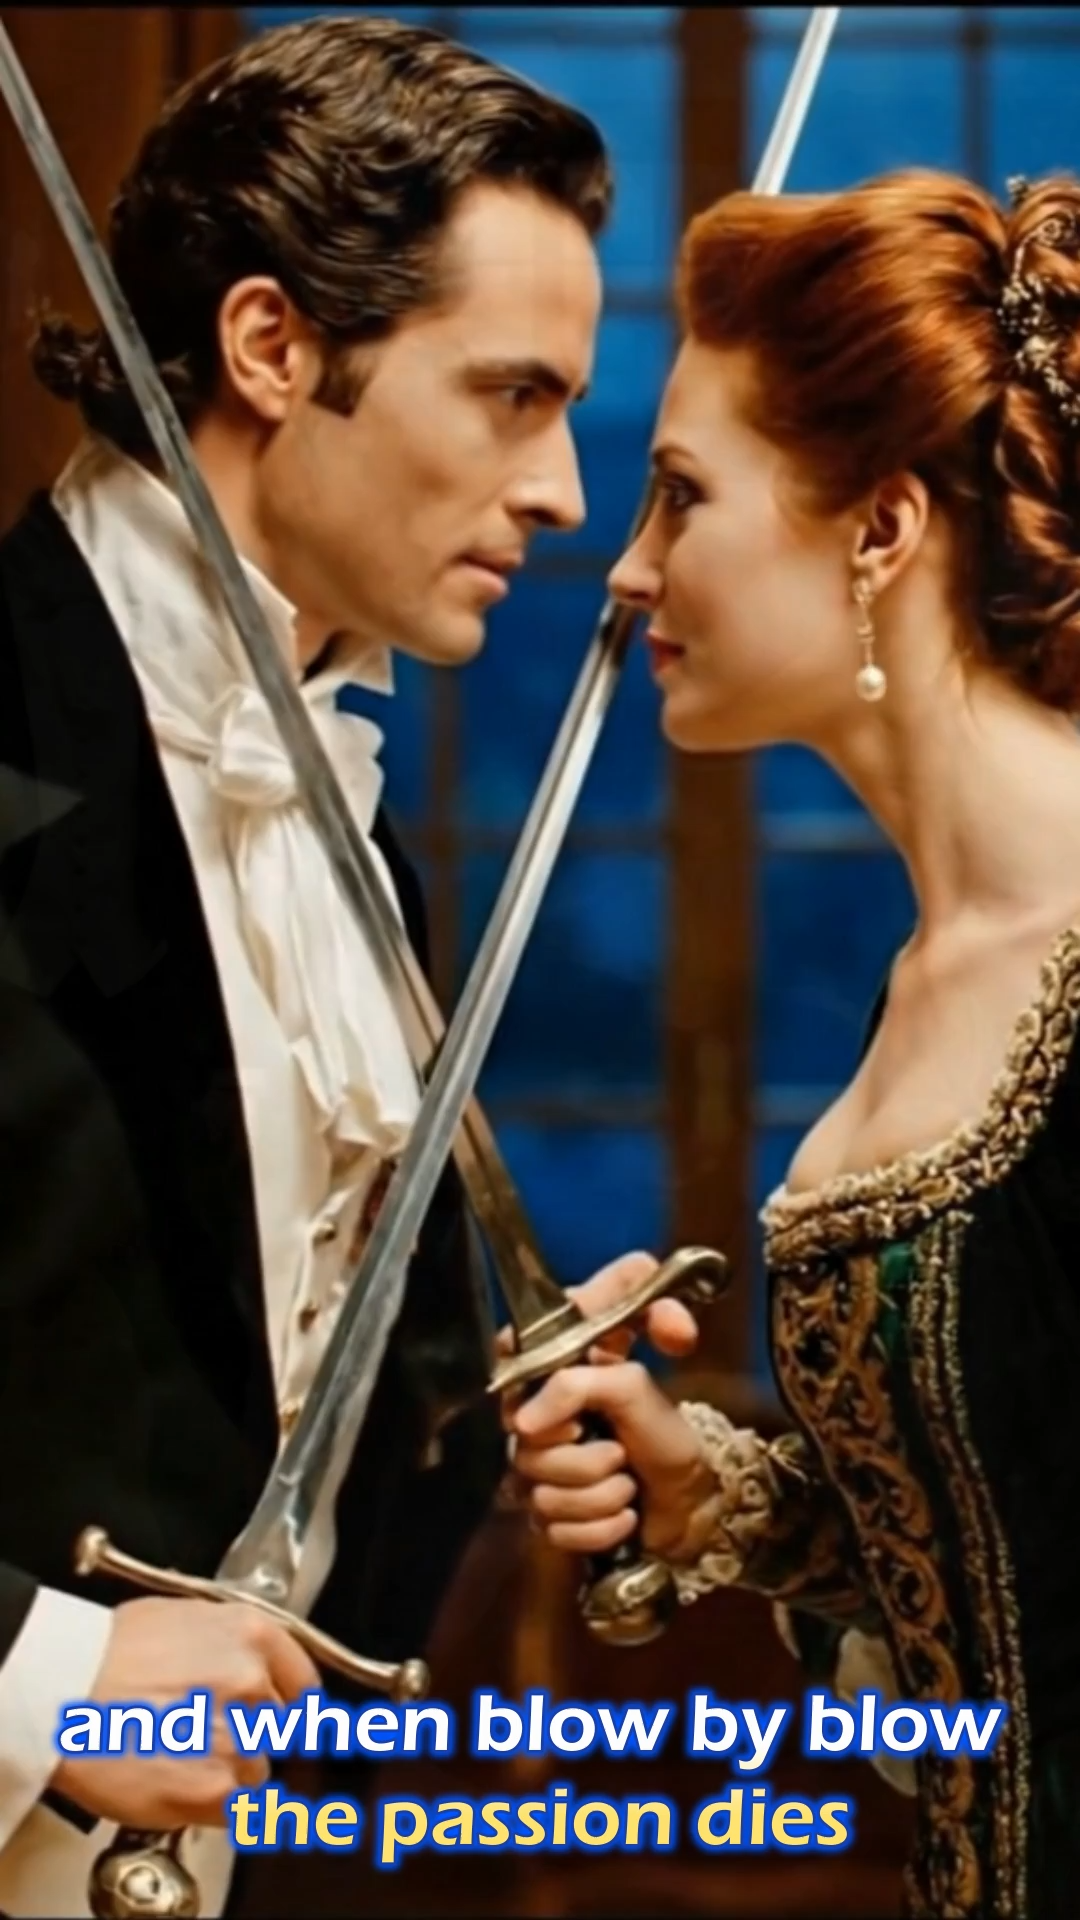

Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 100
Data shape for DDIM sampling is (1, 3, 1920, 1080), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler:  49%|████▉     | 49/100 [29:10<30:22, 35.73s/it]

In [ ]:
#@title # Do stuff
input = "frame_980.png" #@param {type:"string"}
output_dir = "/content/" #@param {type:"string"}
steps = 100 #@param {type:"integer"}

uniq_id = gen_id()

if os.path.isfile(drive_root+input):
  inputs = [drive_root+input]
  dir_in = path_dir(drive_root+input)
elif os.path.isdir(drive_root+input):
  dir_in = drive_root+fix_path(input)
  # What to do if input is directory path
  inputs = list_images(dir_in)
elif os.path.isdir(drive_root+input) and '*' in input:
  dir_in = path_dir(drive_root+input)
  inputs = glob(drive_root+input)
else:
  op(c.fail, 'FAIL!', 'Input should be a path to an image file or a directory of image files.')
  sys.exit('Input not understood.')

# Output
if output_dir == '':
  dir_out = dir_in
else:
  if not os.path.isdir(drive_root+output_dir):
    os.mkdir(drive_root+output_dir)
  dir_out = drive_root+fix_path(output_dir)

total = len(inputs)
timer_start = time.time()

# -- DO THINGS --
for i, input in enumerate(inputs, 1):
  ndx = str(i) + '/' + str(total) + ' '
  op(c.title, ndx+'Processing', input.replace(drive_root, ''), time=True)
  temp_img = Image.open(input).convert('RGB')
  input_fixed = input.replace('.png', '_fixed.png')
  temp_img.save(input_fixed)
  # ---------------------------------------

  img_out = dir_out+uniq_id+'_'+str(steps)+'steps_'+path_leaf(input)

  # OCCHIO: Qui cambiamo 'input' con 'input_fixed'
  logs = run(model["model"], input_fixed, mode.value, steps)

  sample = logs["sample"]
  img_out = dir_out+uniq_id+'_'+str(steps)+'steps_'+path_leaf(input)
  logs = run(model["model"], input, mode.value, steps)

  sample = logs["sample"]
  sample = sample.detach().cpu()
  sample = torch.clamp(sample, -1., 1.)
  sample = (sample + 1.) / 2. * 255
  sample = sample.numpy().astype(np.uint8)
  sample = np.transpose(sample, (0, 2, 3, 1))
  a = Image.fromarray(sample[0])
  a.save(img_out)

  if os.path.isfile(img_out):
    # display(a)
    op(c.ok, 'Upscaled image saved as', img_out.replace(drive_root, ''))
  else:
    op(c.fail, 'Error occurred: ', input.replace(drive_root, ''))

# -- END THINGS --

timer_end = time.time()

print('\nElapsed', timedelta(seconds=timer_end-timer_start))
op(c.ok, 'FIN.')
